In [1]:
import os

if "jbook" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))
import warnings

warnings.filterwarnings("ignore")
FORCE = False

# AppVoCAI Dataset Unboxing
In this section, we unbox the dataset, survey its key characteristics, profile its structure, format, and data types, then register it as an asset, prior to downstream data quality assessment, cleaning, enrichment and analysis activities.

In [2]:
import logging
import matplotlib.pyplot as plt

from discover.app.eda import EDA
from discover.container import DiscoverContainer
from discover.infra.config.flow import FlowConfigReader
from explorify.eda.visualize.visualizer import Visualizer
from discover.core.flow import DataPrepStageDef, PhaseDef
from discover.flow.data_prep.ingest.stage import IngestStage
from discover.infra.utils.visual.print import Printer

In [3]:
container = DiscoverContainer()
container.init_resources()
container.wire(
    modules=[
        "discover.flow.data_prep.stage",
        "discover.app.base",
    ],
)

## Ingest Data
The ingestion process reads the raw data, performs pre-conditioning of the data, such as adding review length to the dataset, then registers the dataset in the repository as an immutable asset, enforcing our write-once-read many (WORM) data management policy.

In [4]:
# Obtain the configuration
reader = FlowConfigReader()
stage_config = reader.get_stage_config(
    phase=PhaseDef.DATAPREP, stage=DataPrepStageDef.INGEST
)

# Build and run Data Ingestion Stage
stage = IngestStage.build(stage_config=stage_config, force=FORCE)
asset_id = stage.run()



# ============================================================================== #
#                              Data Ingestion Stage                              #
# ============================================================================== #



                              Data Ingestion Stage                              
                           Stage Started | Mon, 11 Nov 2024 03:26:16
                         Stage Completed | Mon, 11 Nov 2024 03:26:16
                           Stage Runtime | 0.01 seconds
                           Cached Result | True


# ============================================================================ #



## AppVoCAI Dataset Summary
Let's  load the data and summarize the data.

In [5]:
# Instantiate the repository
repo = container.repo.dataset_repo()
# Load the dataset from the repository
df = repo.get(asset_id=asset_id).content

In [6]:
# Instantiate the Review analyzer object
reviewalizer = EDA(df=df)
reviewalizer.summary()



                            AppVoCAI Dataset Summary                            
                       Number of Reviews | 86,705
                     Number of Reviewers | 86,431
              Number of Repeat Reviewers | 271
         Number of Influential Reviewers | 5,374
                          Number of Apps | 9,847
                    Number of Categories | 14
                                Features | 12
                        Memory Size (Mb) | 58.15
                    Date of First Review | 2020-01-01 00:24:26
                     Date of Last Review | 2023-09-03 02:04:28


As evidenced here and stated earlier, The AppVoCAI captures over 22 million reviews from nearly 16 million users. These reviews span some 36,377 apps across 14 categories. The dataset contains 11 features and spans from July 10, 2008, the date the appstore launched, through early September of 2023.

## Structural Analysis
Before examining the content of the dataset, let's inspect its format and structure. 

In [7]:
reviewalizer.info()

,Column,DataType,Complete,Null,Completeness,Unique,Duplicate,Uniqueness,Size (Bytes)
0,id,string[python],86705,0,1.0,86705,0,1.000000,5815040
1,app_id,string[python],86705,0,1.0,9847,76858,0.113569,5763687
2,app_name,string[python],86705,0,1.0,9843,76862,0.113523,7055255
3,category_id,category,86705,0,1.0,14,86691,0.000161,88115
4,author,string[python],86705,0,1.0,86431,274,0.996840,6676285
5,rating,Int16,86705,0,1.0,5,86700,0.000058,260115
6,content,string[python],86705,0,1.0,81357,5348,0.938320,42690162
7,vote_sum,Int64,86705,0,1.0,63,86642,0.000727,780345
8,vote_count,Int64,86705,0,1.0,74,86631,0.000853,780345
9,date,datetime64[ms],86705,0,1.0,86627,78,0.999100,693640


Several impressions:

1. **ID and Uniqueness**: The `id` column is showing some duplication (117 items) which will require treatment during the data cleaning stage.

2. **App-Specific Details (`app_id`, `app_name`)**: The cardinality of `app_id` exceeds that of `app_name` by 14, which indicates that some apps may have multiple ids, perhaps to uniquely identify different versions of the same app.

3. **Category Distribution**:  `category_id` and `category` are consistent, each with only 14 unique categories, suggesting clear category classifications across apps. 

4. **Authors and Reviews**: Duplication stats for the `author` column indicate that approximately 29% of the authors have submitted multiple reviews; yet, the vast majority of authors in the dataset have minimal engagement. 

5. **Rating Consistency**: The `rating` column has only 5 unique values, presumably in [1,5], to be confirmed below.

6. **Vote Metrics (`vote_count`, `vote_sum`)**: Both `vote_count` and `vote_sum` have low uniqueness (0.075% and 0.057%), suggesting that vote distributions are limited in range, possibly clustering around common values.

7. **Review Content**: Review content occupies approximately 8 Gb of memory, with a duplication rate approaching 14% (3,086,628 reviews). Duplication in text-based user generated content often indicates common patterns such as emojis and sentiment expressions throughout the dataset.

8. **Date**: Review `date` is appropriately typed as a datetime64 objects, representing an offset from 1970-01-001T00:00:00. Values range from 2008-07-10 10:15:37 to 2023-09-03 02:14:35.

9. **Data Completeness**: All columns are 100% complete, with no missing values, ensuring the dataset’s integrity for analysis.

10. **Data Format:** Most of the variables are appropriately typed. Casting `category_id` to category, and converting *object* types to *string* types will improve IO, storage efficiency and memory utilization.  

11. **Data Volume and Memory Considerations**: The dataset weighs in at about 4.9 Gb of memory, which may require special consideration during data preprocessing, analysis, and modeling stages. For instance, certain aggregations and computationally expensive analytics can be precomputed and re-used during the analysis stages, avoiding expensive calculations and supporting real-time analytics, and decreased iteration cycle times. 



## Category Coverage
The dataset spans 14 categories. Let's examine their distribution in terms of counts and proportions.

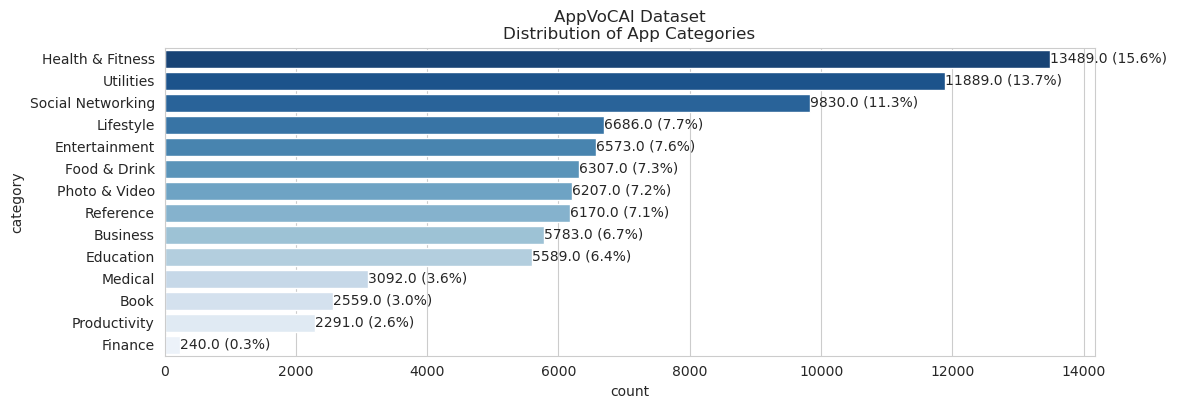

In [8]:
viz = Visualizer()
ax = viz.countplot(
    data=df,
    y="category",
    title="AppVoCAI Dataset\nDistribution of App Categories",
    order_by_count=True,
    plot_counts=True,
)

The distribution of reviews by app category in the AppVoCAI dataset provides insight into how review data is represented within this particular dataset, rather than reflecting any actual usage or popularity patterns in the app store at large.

1. **Higher Representation in Health & Fitness, Utilities, and Social Networking**: Categories such as Health & Fitness (17.8%), Utilities (13.2%), and Social Networking (12.3%) have the largest share of reviews in this dataset. This may reflect the way data was randomly sampled, rather than indicating a larger user base or greater engagement in these categories across the app store.

2. **Diverse Representation Across Lifestyle, Entertainment, and Food & Drink**: Categories like Lifestyle, Entertainment, and Food & Drink are also well represented in this dataset, accounting for a moderate portion of the reviews. Again, this distribution may simply result from the dataset's random sampling approach, rather than indicating broader trends.

3. **Lower Review Counts in Finance and Medical**: Some categories, such as Finance (0.2%) and Medical (2.8%), show fewer reviews in this dataset. This does not imply these categories are less popular or less reviewed in the app store but simply reflects the structure of this specific dataset.

4. **Focus on Dataset-Specific Insights**: While this distribution does not represent actual app store trends, it does provide an opportunity to examine patterns and themes within each category as represented in this dataset. For example, the high representation of certain categories might allow for a richer analysis of user sentiment or feature requests in those domains.

Again, this distribution should be viewed as unique to the AppVoCAI dataset, shaped by the random and stochastic nature of the acquisition process rather than as a representation of category popularity or review volume in the broader app store context.

## AppVoCAI Dataset Sample Observations 
To gain an initial, qualitative sense of the AppVoCAI dataset, let's take an early peek at a few randomly selected observations from the dataset. 

In [9]:
samples = df.sample(n=5, random_state=2)
samples

,id,app_id,app_name,category_id,author,rating,content,vote_sum,vote_count,date,review_length,category
47697,6979119107,1169136078,Huckleberry: Baby & Child,6020,729065dc5096a521e94f,5,This app is such a lifesaver for us!,0,0,2021-02-10 23:03:12,36,Medical
2275,5959525641,1248062869,Lure: Interactive Chat Stories,6018,ff2c0bd4a1cae801cd4f,5,This app is nice but I hate it when I have to ...,0,0,2020-05-18 02:55:00,116,Book
85864,6778859348,594039512,PagerDuty,6002,89c9dd80740cd27c8b4d,1,Pointless to get rid of the hamburger icon in ...,0,0,2020-12-21 20:28:25,280,Utilities
51910,6493256138,544007664,"YouTube: Watch, Listen, Stream",6008,502d8a7bdc5ad24b5c68,5,I watch funny vids that really inspire me and ...,0,0,2020-10-02 19:31:59,92,Photo & Video
81424,8400088487,663592361,DuckDuckGo Private Browser,6002,b2eaeba54857fbbab8c0,5,Works well!,0,0,2022-02-27 00:49:34,11,Utilities


The sample includes a mix of highly rated apps, as well as lower ratings, all of which reflect different user experiences. The reviews span a significant time range, from as early as 2014 to as recent as 2023, showcasing both historical and recent user sentiments. However, a common feature across the sample is the absence of votes (both vote count and vote sum are zero). The EDA will illuminate the degree to which low engagement interaction is endemic or an aspect of our sample.

### Starbucks

In [10]:
printer = Printer()
printer.print_dataframe_as_dict(
    df=samples, list_index=0, title=samples["app_name"].values[0], text_col="content"
)



                           Huckleberry: Baby & Child                            
                                      id | 6979119107
                                  app_id | 1169136078
                                app_name | Huckleberry: Baby & Child
                             category_id | 6020
                                  author | 729065dc5096a521e94f
                                  rating | 5
                                vote_sum | 0
                              vote_count | 0
                                    date | 2021-02-10 23:03:12
                           review_length | 36
                                category | Medical
This app is such a lifesaver for us!


This review provides an insightful example of user feedback with both positive and negative elements. Here’s a breakdown of its content and potential implications for further analysis:

1. **Positive Acknowledgment of Design**: The user begins by appreciating the "new look" of the Starbucks app, indicating that recent visual or interface updates have been well-received. Positive mentions like this can highlight which design or functionality aspects resonate with users, useful information for product teams.

2. **Error in Notification System**: The main issue raised by the user is with the app's notification system. They report receiving incorrect notifications about their card balance, despite no actual change. This points to a potential bug or glitch where users are receiving notifications meant for other accounts, which could be a serious privacy or security concern. This is valuable feedback for the development and quality assurance teams.

3. **Trust and Reliability Concerns**: The user’s experience highlights a significant trust issue. Even though they verified their balance was correct upon checking, the fact that incorrect notifications were sent could undermine their confidence in the app. Users rely on financial apps to handle sensitive information accurately, and errors like these could harm the app’s reputation if widespread.

4. **Category Context**: This review falls under the "Food & Drink" category, where reliability, especially regarding financial transactions, is critical. Errors in financial notifications are likely to be a high-priority issue for this category, where users frequently manage balances and payments.

5. **Rating**: With a low rating of 2.0, this review contributes to a negative sentiment toward the app. This rating, combined with the detailed description of the issue, suggests that this bug significantly impacted the user’s experience.

**Implications for Analysis**: This review underscores the importance of checking for themes around notification accuracy and user trust, especially in categories that involve financial transactions. In an Aspect-Based Sentiment Analysis (ABSA) process, aspects like “design” (positive) and “notifications” or “balance accuracy” (negative) could be identified. This review also highlights how user trust can be impacted by seemingly minor but persistent bugs, making it an important consideration for opportunity discovery in this app's improvement.

### T-Mobile

In [11]:
printer.print_dataframe_as_dict(
    df=samples, list_index=1, title=samples["app_name"].values[1], text_col="content"
)



                         Lure: Interactive Chat Stories                         
                                      id | 5959525641
                                  app_id | 1248062869
                                app_name | Lure: Interactive Chat Stories
                             category_id | 6018
                                  author | ff2c0bd4a1cae801cd4f
                                  rating | 5
                                vote_sum | 0
                              vote_count | 0
                                    date | 2020-05-18 02:55:00
                           review_length | 116
                                category | Book
This app is nice but I hate it when I have to wait for three hours to get six
gems I wish they put 10 gems instead 🥺


This review provides strong negative feedback, focusing on customer service and account management issues. Here’s an analysis of its key elements:

1. **Frustration with Customer Service**: The reviewer expresses intense dissatisfaction with T-Mobile’s customer service, specifically citing “incompetence” and a lack of training among staff. This indicates that, from the user’s perspective, T-Mobile employees lack the necessary knowledge or skills to handle customer accounts effectively. Such feedback points to a perceived gap in customer service quality, which could have implications for both training programs and customer service policies.

2. **Urgency and Emotional Intensity**: Words like “absolutely horrific” and the use of all caps in “IMMEDIATELY” emphasize the user’s frustration and sense of urgency. This heightened emotional tone suggests that the experience may have significantly affected the user’s perception of T-Mobile, potentially leading to a loss of loyalty or trust. High-intensity language like this could be flagged in sentiment analysis as a strong indicator of negative sentiment.

3. **Rating**: The review is rated 1.0, the lowest possible score, which aligns with the severe dissatisfaction expressed in the text. This low rating adds weight to the feedback, highlighting the negative impact of the experience on the user’s overall view of the company.

4. **Lack of Specific Details**: Although the review conveys intense dissatisfaction, it lacks specific examples of what went wrong. This lack of detail can make it challenging for the company to pinpoint and address the exact issues. However, the general sentiment still provides valuable insight into potential areas of improvement in training and customer service protocols.

5. **Category Context**: As a “Utilities” app, T-Mobile’s app likely serves a functional purpose, providing access to account management and customer service. Poor customer service experiences are especially damaging in utility apps, as users expect efficient and reliable support when managing essential services like mobile accounts.

**Implications for Analysis**: This review highlights the importance of customer service competence and the need for effective employee training in handling accounts. In an Aspect-Based Sentiment Analysis (ABSA), aspects like “customer service” and “employee knowledge” could be flagged with strong negative sentiment. The urgency and intensity of the language also suggest that T-Mobile may need to prioritize improvements in its customer service quality to prevent similar negative experiences. This review serves as a reminder that even without specific details, user feedback can signal underlying systemic issues in customer support and account management that may require attention.

### Human Anatomy Atlas 2023

In [12]:
printer.print_dataframe_as_dict(
    df=samples, list_index=2, title=samples["app_name"].values[2], text_col="content"
)



                                   PagerDuty                                    
                                      id | 6778859348
                                  app_id | 594039512
                                app_name | PagerDuty
                             category_id | 6002
                                  author | 89c9dd80740cd27c8b4d
                                  rating | 1
                                vote_sum | 0
                              vote_count | 0
                                    date | 2020-12-21 20:28:25
                           review_length | 280
                                category | Utilities
Pointless to get rid of the hamburger icon in the top left and rely on the user
to KNOW they should swipe to reveal.   Menu items no longer work after the
update (clicking My On Call Shifts does not actually open the page, for
example).   Please just keep the app simple and fast.


This review provides positive feedback, focusing on the app’s functionality and customer support effectiveness. Here’s an analysis of its key elements:

1. **Satisfaction with the App**: The reviewer expresses strong satisfaction with the **Human Anatomy Atlas 2023** app, appreciating its functionality and usefulness. This endorsement suggests that the app meets or exceeds the user’s expectations for an educational tool in the Medical category, providing value to users looking to explore anatomical information.

2. **Effective Customer Support**: The user reports a positive experience with customer support after encountering an issue with the app loading following an iOS update. They mention reaching out, providing proof of purchase, and having the issue resolved. This feedback highlights the responsiveness and helpfulness of the customer support team, which is a significant factor in user satisfaction, particularly when technical issues arise due to system updates.

3. **Rating**: The review is rated 5.0, the highest possible score, aligning with the user’s positive experience. This high rating reinforces the value the user places on both the app’s functionality and the quality of customer support.

4. **Issue Resolution**: Although the user experienced a loading issue, their positive response suggests that prompt and effective customer support can mitigate frustration and even enhance user satisfaction. This review indicates that addressing issues quickly and respectfully can turn potentially negative experiences into positive ones.

5. **Category Context**: As a Medical app, **Human Anatomy Atlas 2023** is likely expected to provide reliable, educational resources, where users rely on the app for study or professional reference. Effective customer support is especially important in this context, as users depend on the app’s consistent functionality.

**Implications for Analysis**: This review underscores the importance of customer support in maintaining high user satisfaction, even when technical issues occur. In an Aspect-Based Sentiment Analysis (ABSA), aspects like “customer support” and “app reliability” could be flagged with positive sentiment. This review demonstrates that customer support is crucial in Medical apps, where users depend on the app’s reliability and responsiveness to issues.

### BetterSleep: Relax and Sleep                          


In [13]:
printer.print_dataframe_as_dict(
    df=samples, list_index=3, title=samples["app_name"].values[3], text_col="content"
)



                         YouTube: Watch, Listen, Stream                         
                                      id | 6493256138
                                  app_id | 544007664
                                app_name | YouTube: Watch, Listen, Stream
                             category_id | 6008
                                  author | 502d8a7bdc5ad24b5c68
                                  rating | 5
                                vote_sum | 0
                              vote_count | 0
                                    date | 2020-10-02 19:31:59
                           review_length | 92
                                category | Photo & Video
I watch funny vids that really inspire me and that’s how I’m a actor and a skate
boarder now


This review provides positive feedback, focusing on the app’s effectiveness in helping the user improve their sleep. Here’s an analysis of its key elements:

1. **Satisfaction with App Functionality**: The reviewer expresses strong satisfaction with **BetterSleep: Relax and Sleep**, emphasizing that the app has positively impacted their sleep quality. This indicates that the app meets its intended purpose, providing effective tools or content for relaxation and sleep improvement.

2. **Emotion and Tone**: The tone of the review is enthusiastic and appreciative, with the user conveying genuine happiness with the app’s impact. Phrases like "Love it!" reinforce this positive sentiment, suggesting that the app has made a noticeable difference in the user’s daily life.

3. **Rating**: The review is rated 5.0, the highest possible score, which aligns with the positive feedback. This high rating reinforces the effectiveness of the app for this particular user, potentially indicating strong alignment between the app's purpose and user expectations.

4. **Brevity and Clarity**: Although the review is brief, it effectively communicates the user’s satisfaction and the app’s perceived value. The concise feedback serves as a quick but clear endorsement of the app’s effectiveness in promoting better sleep.

5. **Category Context**: As a Health & Fitness app, **BetterSleep: Relax and Sleep** is expected to support users’ well-being, in this case by aiding sleep quality. Positive reviews in this category are particularly valuable, as they may help build trust among potential users seeking solutions for sleep-related issues.

**Implications for Analysis**: This review highlights the app’s success in delivering on its promise to improve sleep, an important aspect for Health & Fitness apps targeting well-being and relaxation. In an Aspect-Based Sentiment Analysis (ABSA), aspects like “effectiveness” and “sleep improvement” could be flagged with positive sentiment. This review suggests that **BetterSleep** is well-received by users looking for accessible and effective sleep aids.

### MyFitnessPal: Calorie Counter App Review

In [14]:
printer.print_dataframe_as_dict(
    df=samples, list_index=4, title=samples["app_name"].values[4], text_col="content"
)



                           DuckDuckGo Private Browser                           
                                      id | 8400088487
                                  app_id | 663592361
                                app_name | DuckDuckGo Private Browser
                             category_id | 6002
                                  author | b2eaeba54857fbbab8c0
                                  rating | 5
                                vote_sum | 0
                              vote_count | 0
                                    date | 2022-02-27 00:49:34
                           review_length | 11
                                category | Utilities
Works well!


This review provides positive feedback, focusing primarily on the quality of customer support rather than the app itself. Here’s an analysis of its key elements:

1. **Praise for Customer Support**: The reviewer specifically commends a customer support representative named Quinshay for their detailed and responsive approach to addressing user concerns. This suggests that Quinshay’s assistance left a strong, positive impression, showcasing ABC’s commitment to user satisfaction and problem-solving.

2. **Unique Motivation for Rating**: Although the reviewer hasn’t fully used the app yet, they still awarded it a 5-star rating based on their experience with customer support. This unique motivation highlights the importance of attentive and proactive support, which can positively impact perceptions even before users engage with the app’s core features.

3. **Emotion and Tone**: The review is enthusiastic and appreciative, conveying a sense of trust and admiration for the ABC app team’s commitment to addressing user feedback. The use of phrases like “KUDOS TO YOU, ABC!!” and emoji (e.g., thumbs up, sunglasses) further emphasizes the user’s positive emotions and satisfaction.

4. **Rating**: The 5.0 rating reflects the reviewer’s appreciation for the customer support experience, which they see as indicative of a customer-centric approach. This high rating, despite limited app usage, underscores how exceptional support can strongly influence user perception.

5. **Category Context**: As an Entertainment app, **ABC: Stream TV Series & Sports** caters to users seeking on-demand content. While users might primarily engage with such an app for content streaming, this review highlights that customer support quality can be a pivotal factor in building brand loyalty and positive user sentiment, even in entertainment contexts.

**Implications for Analysis**: This review underscores the value of customer support as a key factor in user satisfaction and perception. In an Aspect-Based Sentiment Analysis (ABSA), aspects like “customer support responsiveness” and “user engagement” could be flagged with positive sentiment. This feedback demonstrates that timely, personalized responses can foster trust and loyalty, potentially encouraging other users to engage more with the app.

## Summary 
Our overview of the AppVoCAI dataset confirms a robust collection of 22.2 million reviews, submitted by approximately 15.7 million users across 36,377 apps. A comprehensive structural analysis assessed data types, row and dataset completeness, duplication, cardinality, and overall dataset size. We found the dataset to be fully complete, with no missing values and no duplicate rows. However, field-level duplication was identified in the review `id` variable, affecting 117 observations, and in the review `content` field, where approximately 14% of entries are duplicated. 

## Next Steps
It's a settled debate: data quality is *still* a vital determining factor in AI model performance, accurate analytics, and data-driven decision making {cite}`jainOverviewImportanceData2020a`, with data quality dimensions such as *completeness*, *validity*, *consistency*, and *diversity* accounting for most of the *variance* in model performance {cite}`budachEffectsDataQuality2022`. For Large Language Models (LLMs), text quality upper bounds their ability to accurately capture, and understand the nuances, complexities, and subtleties of human language. High quality text data ensures nuances are preserved, allowing models to more effectively perform tasks such as sentiment analysis, question/answering, language prediction. 

The next stage in our workflow positions ourselves for a structured and exhaustive quality analysis. We'll enrich the data with review-level sentiment classifications to assess class balance; while, text quality assessments will illuminate the syntactic complexity, lexical sophistication, and coherence  - critical for LLM fine-tuning. By embracing data enrichment at this stage, we derive greater value from our data quality and exploratory efforts downstream.